In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
from sklearn.linear_model import LinearRegression

#### Read in data

In [6]:
data = pd.read_csv("D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\ar1.csv")

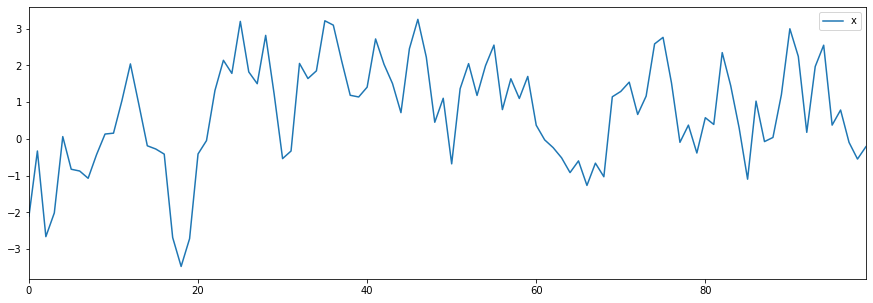

In [7]:
data.plot.line(figsize = (15, 5))

#### Hypothesis test for autocorrelation

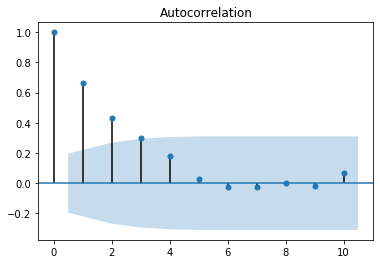

In [8]:
_ = plot_acf(data.x, lags=10)

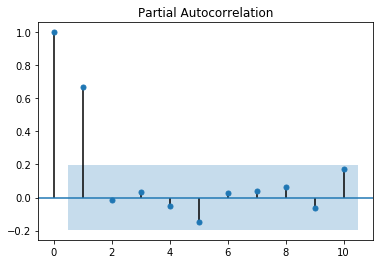

In [9]:
_ = plot_pacf(data.x, lags=10)

In [10]:
# ljungbox test for autocorrelation
st.ljungbox_(data.x)

Statistics=78.355, p=0.000
There is correlation up to lag 10 (reject H0)


#### Hypothesis test for normality

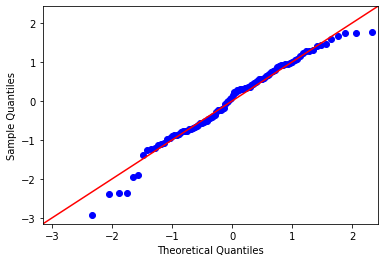

In [11]:
fig = sm.qqplot(data.x, fit=True, line='45')
plt.show()

In [12]:
# shapiro-wilks test for normality
st.shapiro_wilks_(data.x, alpha=0.05)

Statistics=0.975, p=0.052
Sample looks Gaussian (fail to reject H0)


In [13]:
# jarque-bera test for normality
st.jarque_bera_(data.x, alpha=0.05)

Statistics=3.292, p=0.193, skew=-0.444, kurt=2.956
Sample looks Gaussian (fail to reject H0)


#### Get in control mean

In [14]:
# Get in-control mean
data.x.mean()

0.7086934456307161

In [15]:
in_control_mean = data.x.mean()

#### Get in control moving range

In [16]:
MR = cp.calculate_MR(data.x)

In [17]:
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [18]:
in_control_sigma

0.8377655375001949

#### Build individual control chart

In [19]:
x_ind_params_df = cp.x_ind_params(x = data.x, sigma = in_control_sigma, center = in_control_mean)

In [20]:
x_ind_params_df = x_ind_params_df.reset_index()

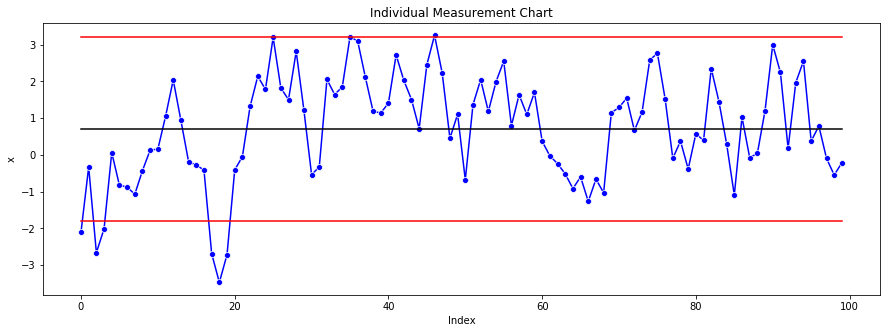

In [21]:
pf.plot_control_chart(
    data = x_ind_params_df,
    index = 'index',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    title='Individual Measurement Chart',
    ylab='x',
    xlab='Index',
    all_dates=False,
    rot=0)

#### Try simple AR1 model

In [22]:
data2 = data.copy()

In [23]:
data2['x1'] = data2['x'].shift(periods = 1)

In [24]:
data2.dropna(inplace = True)

In [25]:
features = ['x1']

In [26]:
lm = LinearRegression(fit_intercept=True)
lm.fit(data2.loc[:, features].values, data2['x'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
lm.intercept_, lm.coef_

(0.2589915749559893, array([0.66589723]))

In [28]:
# get residuals
residuals = pd.Series(data2['x'].values - lm.predict(data2.loc[:, features].values))

#### Test for Autocorrelation

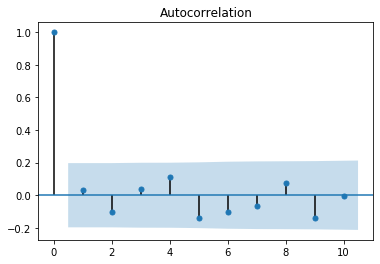

In [29]:
_ = plot_acf(residuals, lags=10)

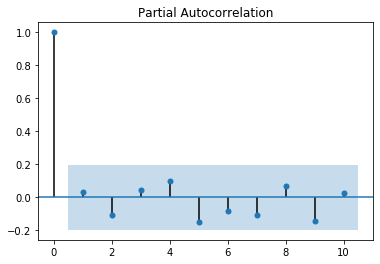

In [30]:
_ = plot_pacf(residuals, lags=10)

In [31]:
st.ljungbox_(residuals, print_extra=True)

Statistics=8.998, p=0.532
No auto correlation up to lag 10 (fail to reject H0)


[0.0909722  1.16253197 1.31944111 2.58175801 4.71417027 5.84128895
 6.30127625 6.88265835 8.99677041 8.99789718]
[0.76294482 0.55918999 0.72452185 0.63005799 0.45174901 0.44120198
 0.50504405 0.54934438 0.43757236 0.53230315]


#### Hypothesis test for normality

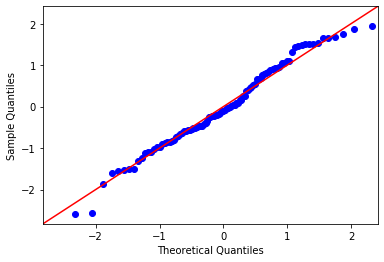

In [32]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

In [33]:
st.shapiro_wilks_(residuals)

Statistics=0.981, p=0.158
Sample looks Gaussian (fail to reject H0)


In [34]:
st.jarque_bera_(residuals)

Statistics=0.780, p=0.677, skew=-0.060, kurt=2.582
Sample looks Gaussian (fail to reject H0)


#### Individual control chart for residuals

In [35]:
in_control_mean = 0

In [36]:
MR = cp.calculate_MR(residuals)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [37]:
in_control_mean, in_control_sigma

(0, 1.0722371717243382)

In [38]:
full_residuals = residuals

In [39]:
x_ind_params_df = cp.x_ind_params(x=full_residuals, sigma = in_control_sigma, center=in_control_mean)
x_ind_params_df = x_ind_params_df.reset_index()

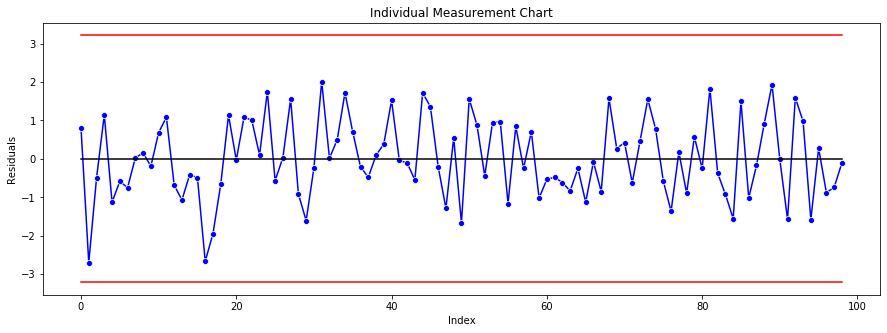

In [40]:
pf.plot_control_chart(
    data = x_ind_params_df,
    index = 'index',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    title='Individual Measurement Chart',
    ylab='Residuals',
    xlab='Index',
    all_dates=False,
    rot=0)

#### Plot original measure chart

In [41]:
x_ind_params_df2 = fn.convert_residuals_to_original(chart_df = x_ind_params_df, 
                                                    predictions = lm.predict(data2.loc[:, features].values))

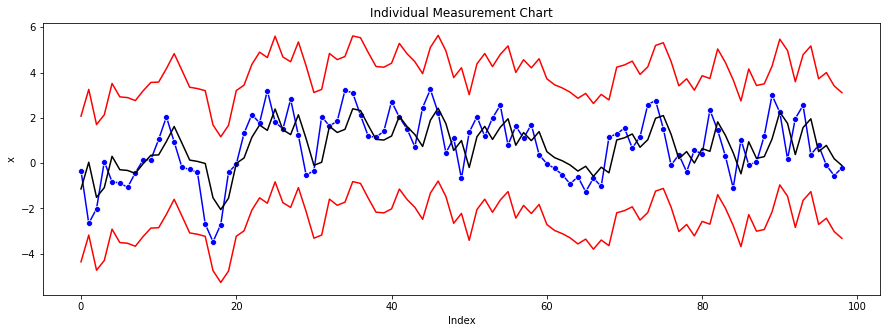

In [42]:
pf.plot_control_chart(
    data = x_ind_params_df2,
    index = 'index',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    drawstyle='default',
    title='Individual Measurement Chart',
    ylab='x',
    xlab='Index',
    all_dates=False,
    rot=0)